In [11]:
from tnia.deconvolution.forward import forward
from tnia.deconvolution.gaussian_psf import gaussian_2d
import raster_geometry as rg
import numpy as np
from tnia.simulation.phantoms import add_small_to_large_2d
import matplotlib.pyplot as plt
from tnia.plotting.plt_helper import imshow_multi2d, imshow2d
import math

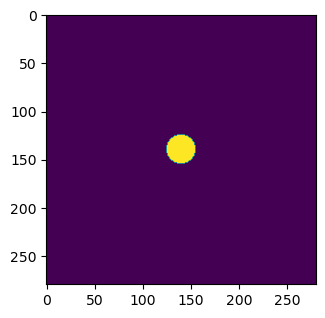

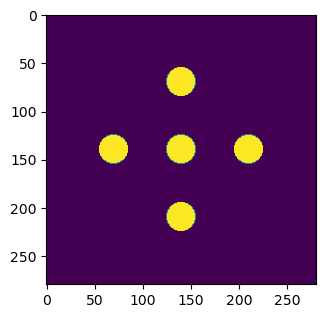

In [69]:
width, height = 280, 280

truth1 = np.zeros([height, width], dtype=np.float32)
truth = np.zeros([height, width], dtype=np.float32)

r = 15
sigma = 3.0
gain = 1000
background = 1

# make a sphere in the middle 
x, y = 140, 140
size = [height//2, width//2]
temp=rg.circle(size, r)
add_small_to_large_2d(truth1, temp, x, y, mode='replace_non_zero')

truth2 = truth1.copy()

x, y = 70, 140
add_small_to_large_2d(truth2, temp, x, y, mode='replace_non_zero')
x, y = 210, 140
add_small_to_large_2d(truth2, temp, x, y, mode='replace_non_zero')
x, y = 140, 70
add_small_to_large_2d(truth2, temp, x, y, mode='replace_non_zero')
x, y = 140, 210
add_small_to_large_2d(truth2, temp, x, y, mode='replace_non_zero')

fig = imshow2d(truth1, width = 8, height = 3.5)
fig = imshow2d(truth2, width = 8, height = 3.5)

In [70]:
psf = gaussian_2d(255,sigma)

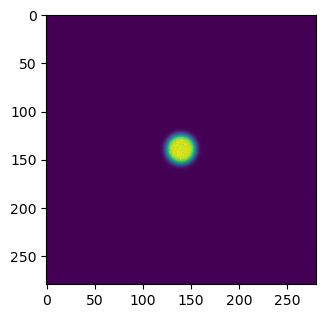

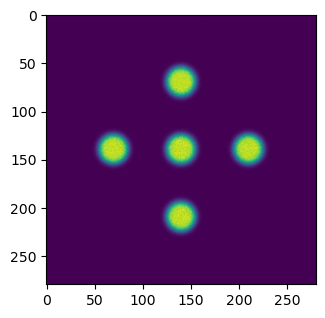

In [71]:
image1 = forward(truth1*gain, psf, background)
image2 = forward(truth2*gain, psf, background)

fig = imshow2d(image1, width = 8, height = 3.5)
fig = imshow2d(image2, width = 8, height = 3.5)

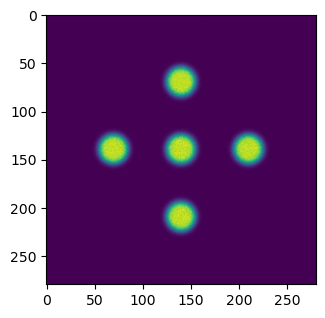

In [72]:
from rl_gradient_concensus import rlgc, pad_psf
import cupy as cp

image1 = np.expand_dims(image1, axis=0)
image2 = np.expand_dims(image2, axis=0)

fig = imshow2d(np.squeeze(image2), width = 8, height = 3.5)


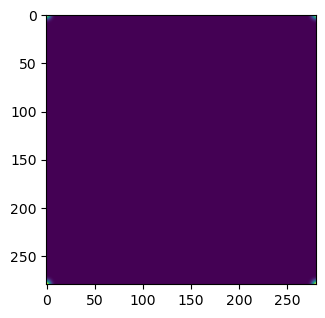

In [73]:
psf = pad_psf(psf, image1)

fig = imshow2d(np.squeeze(psf), width = 8, height = 3.5)

In [74]:
image1_cp = cp.asarray(image1)
image2_cp = cp.asarray(image2)
psf_cp = cp.asarray(psf) 
recon = rlgc(image1_cp, psf_cp, 100, True)

Hu min: 10.12547193877551, max: 10.12547193877551
Iteration 001 completed in 0.005 s. KLDs = 5.3039 (image), 6.9221 (split 1), 6.9410 (split 2). 99.99 % of image updated. Update range: 0.07 to 98.53. Largest relative delta = 0.98985.
Hu min: 0.7480585394473608, max: 983.1930229898295
Iteration 002 completed in 0.005 s. KLDs = 0.4436 (image), 0.6436 (split 1), 0.6451 (split 2). 37.94 % of image updated. Update range: 0.14 to 1.20. Largest relative delta = 0.13429.
Hu min: 0.5355981535687024, max: 1059.9299438629114
Iteration 003 completed in 0.005 s. KLDs = 0.3370 (image), 0.5122 (split 1), 0.5104 (split 2). 33.34 % of image updated. Update range: 0.32 to 1.29. Largest relative delta = 0.06774.
Hu min: 0.4915169747810289, max: 1056.3861265656892
Iteration 004 completed in 0.005 s. KLDs = 0.3169 (image), 0.4839 (split 1), 0.4863 (split 2). 31.03 % of image updated. Update range: 0.46 to 1.35. Largest relative delta = 0.04682.
Hu min: 0.4997514648944328, max: 1049.4131660976313
Iteration 

In [75]:
recon2 = rlgc(image2_cp, psf_cp, 400, True)

Hu min: 46.61181122448981, max: 46.61181122448981
Iteration 001 completed in 0.008 s. KLDs = 6.0921 (image), 7.5726 (split 1), 7.5735 (split 2). 99.96 % of image updated. Update range: 0.01 to 21.45. Largest relative delta = 0.95339.
Hu min: 0.7447992435208535, max: 986.9651283476232
Iteration 002 completed in 0.007 s. KLDs = 0.2103 (image), 0.2853 (split 1), 0.2878 (split 2). 49.82 % of image updated. Update range: 0.14 to 1.21. Largest relative delta = 0.13627.
Hu min: 0.5303236965549735, max: 1064.2008730905725
Iteration 003 completed in 0.005 s. KLDs = 0.0973 (image), 0.1439 (split 1), 0.1430 (split 2). 46.65 % of image updated. Update range: 0.32 to 1.46. Largest relative delta = 0.06838.
Hu min: 0.49596671166431816, max: 1061.6147758289183
Iteration 004 completed in 0.005 s. KLDs = 0.0767 (image), 0.1170 (split 1), 0.1165 (split 2). 42.53 % of image updated. Update range: 0.46 to 1.34. Largest relative delta = 0.04666.
Hu min: 0.4667696835061925, max: 1055.5587542293654
Iteration

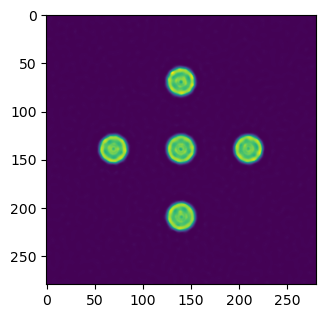

In [60]:
fig = imshow2d(np.squeeze(recon2.get()), width = 8, height = 3.5)